In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import scipy.optimize as so
import matplotlib.pyplot as plt

Scherrer equation:

$\tau=\frac{K\lambda}{\beta cos(\theta)}$

where $K$ is a number of order unity having to do with crystallite shape, $\lambda = 1.54056 Å$ is the x-ray wavelength, $\beta$ is the FWHM of the peak, and $\theta$ is the bragg angle (_NOT_ $2\theta$!!)

In [2]:
def deg_to_rad(a):
    return a*np.pi/180

def scherrer(center, left, right, sto_fwhm):
    return 0.9*1.54056/(deg_to_rad(right-left-sto_fwhm)*np.cos(deg_to_rad(center/2)))

def scherrer_fwhm(center, fwhm, sto_fwhm):
    return 0.9*1.54056/(deg_to_rad(fwhm-sto_fwhm)*np.cos(deg_to_rad(center/2)))

def lorentz(x, A, c, w, offset):
    return offset+A/(1+((c-x)/(0.5*w))**2)

def gauss(x, A, c, w, offset):
    return offset+A*np.exp((-4*np.log(2)*(x-c)**2)/(w**2))

def double_lorentz(x, A1, c1, w1, A2, c2, w2, offset):
    return lorentz(x, A1, c1, w1, 0)+lorentz(x, A2, c2, w2, 0)+offset

def pseudo_voigt(x, A, c, fwhm_g, fwhm_l, offset):
    eta_val = eta(fwhm_g, fwhm_l)
    return eta_val*lorentz(x, A, c, fwhm_l, 0)+(1-eta_val)*gauss(x, A, c, fwhm_g, 0)+offset

def eta(fwhm_g, fwhm_l):
    fwhm_total = (fwhm_g**5 + 2.69269*(fwhm_g**4)*(fwhm_l) + 2.42843*(fwhm_g**3)*(fwhm_l**2) + 4.47163*(fwhm_g**2)*(fwhm_l**3) + 0.07842*(fwhm_g)*(fwhm_l**4) + fwhm_l**5)**0.2
    return 1.36603*(fwhm_l/fwhm_total) - 0.47719*((fwhm_l/fwhm_total)**2) + 0.11116*((fwhm_l/fwhm_total)**3)

In [3]:
data = pd.read_csv('C:/Users/pdmurray/Desktop/peyton/Projects/YBCO_Getters/Data/Combined Datasets/XRD.csv',
                   names=['ag_tth', 'ag_i', '3nm_tth', '3nm_i', '7nm_tth', '7nm_i', '20nm_tth', '20nm_i', 'ta_tth', 'ta_i'],
                   skiprows=2)

c:\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
c:\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


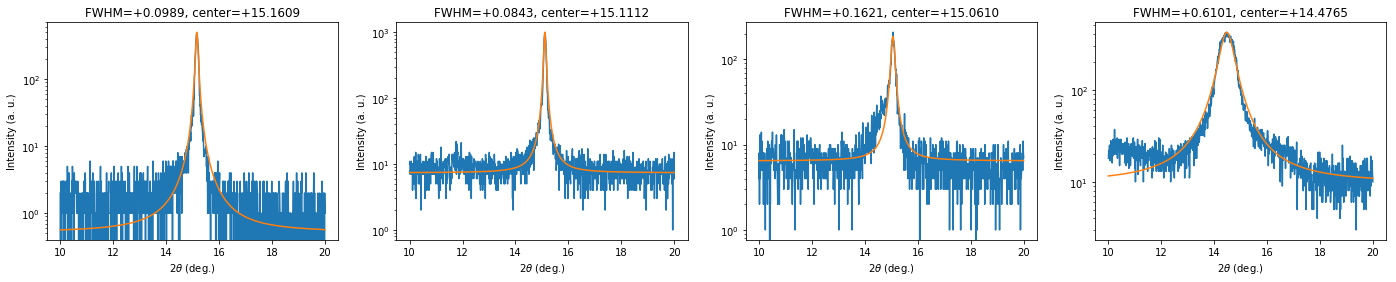

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24,4))

fwhm_film = {}
fwhm_sto = {}
center_film = {}

for index, tth, i, key in zip([0,1,2,3], ['ag_tth', '3nm_tth', '7nm_tth', '20nm_tth'], ['ag_i', '3nm_i', '7nm_i', '20nm_i'], ['ag', '3nm', '7nm', '20nm']):
    mask = np.logical_and(data[tth] <= 20, data[tth] >= 10)
    x = data[tth][mask].values
    y = data[i][mask].values

    res = so.differential_evolution(lambda pars: np.sum((lorentz(x, *pars) - y)**2), bounds=((0, 1e3), (10,20), (0,1), (0,1e3)))
    x_fit = np.linspace(10,20,1000)
    y_fit = lorentz(x_fit, *res.x)

    ax[index].plot(data[tth][mask], data[i][mask])
    ax[index].plot(x_fit, y_fit)
    ax[index].set_title('FWHM={:+4.4f}, center={:+4.4f}'.format(res.x[2], res.x[1]))
    ax[index].set_xlabel('$2\\theta$ (deg.)')
    ax[index].set_ylabel('Intensity (a. u.)')
    ax[index].set_yscale('log', nonposy='clip')
    
    fwhm_film[key] = res.x[2]
    center_film[key] = res.x[1]

c:\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
c:\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


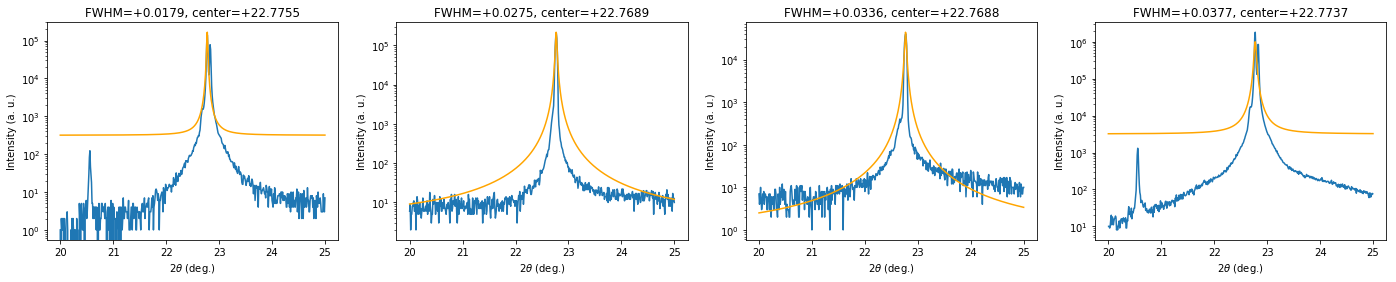

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24,4))
for index, tth, i, key in zip([0,1,2,3], ['ag_tth', '3nm_tth', '7nm_tth', '20nm_tth'], ['ag_i', '3nm_i', '7nm_i', '20nm_i'], ['ag', '3nm', '7nm', '20nm']):
    mask = np.logical_and(data[tth] <= 25, data[tth] >= 20)
    x = data[tth][mask].values
    y = data[i][mask].values

#     res = so.differential_evolution(lambda pars: np.sum((pseudo_voigt(x, *pars) - y)**2), bounds=((0, 1e6), (20,25), (0,1), (0, 1), (0,1e6)))
    res = so.differential_evolution(lambda pars: np.sum((lorentz(x, *pars) - y)**2), bounds=((0, 1e6), (20,25), (0,1), (0,1e6)))
#     res = so.differential_evolution(lambda pars: np.sum((double_lorentz(x, *pars) - y)**2), bounds=((0, 1e6), (20,25), (0,1), (0, 1e6), (20,25), (0,1), (0,1e6)))
    x_fit = np.linspace(20,25,1000)
#     y_fit = pseudo_voigt(x_fit, *res.x)
    y_fit = lorentz(x_fit, *res.x)
#     y_fit = double_lorentz(x_fit, *res.x)
#     y1_fit = lorentz(x_fit, *res.x[0:3], 0)
#     y2_fit = lorentz(x_fit, *res.x[3:6], 0)

    ax[index].plot(data[tth][mask], data[i][mask])
    ax[index].plot(x_fit, y_fit, color='orange')
#     ax[index].set_title('FWHM_G={:+4.4f}\n FWHM_L={:4.4f}\n center={:+4.4f}'.format(res.x[2], res.x[3], res.x[1]))
    ax[index].set_title('FWHM={:+4.4f}, center={:+4.4f}'.format(res.x[2], res.x[1]))
    ax[index].set_xlabel('$2\\theta$ (deg.)')
    ax[index].set_ylabel('Intensity (a. u.)')
    ax[index].set_yscale('log', nonposy='clip')
    
    fwhm_sto[key] = res.x[2]

In [8]:
scherrer_sizes = {key: scherrer_fwhm(center=center_film[key], fwhm=fwhm_film[key], sto_fwhm=fwhm_sto[key]) for key in center_film.keys()}

In [6]:
fwhm_film

{'ag': 0.09901220903767519,
 '3nm': 0.08437136315626798,
 '7nm': 0.16319610474164337,
 '20nm': 0.6100790803015098}

In [20]:
center_film

{'ag': 15.160925258294135,
 '3nm': 15.111333595545805,
 '7nm': 15.060259527013603,
 '20nm': 14.476525753986405}

In [7]:
fwhm_sto

{'ag': 0.017999823883966093,
 '3nm': 0.02752411307026109,
 '7nm': 0.03326863609395502,
 '20nm': 0.03782901621057737}

In [9]:
scherrer_sizes

{'ag': 989.8305921887792,
 '3nm': 1410.4312466237056,
 '7nm': 623.3178842138606,
 '20nm': 139.90252636579902}

Text(0, 0.5, 'Scherrer size')

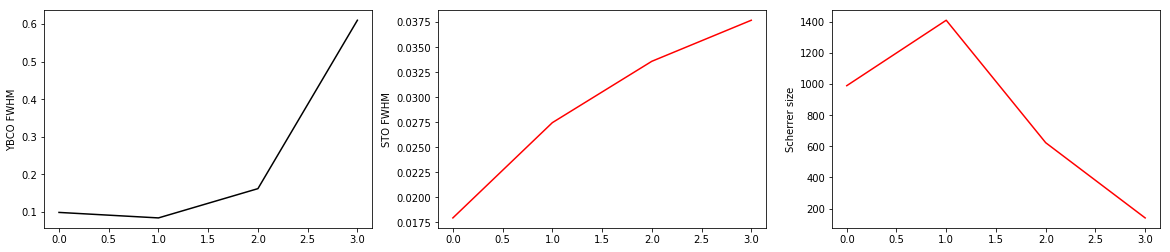

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot([value for key, value in fwhm_film.items()], '-k', label='FWHM YBCO')
ax[0].set_ylabel('YBCO FWHM')
ax[1].plot([value for key, value in fwhm_sto.items()], '-r', label='FWHM STO')
ax[1].set_ylabel('STO FWHM')
ax[2].plot([value for key, value in scherrer_sizes.items()], '-r', label='Scherrer sizes')
ax[2].set_ylabel('Scherrer size')

c:\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


Text(0, 0.5, 'STO FWHM')

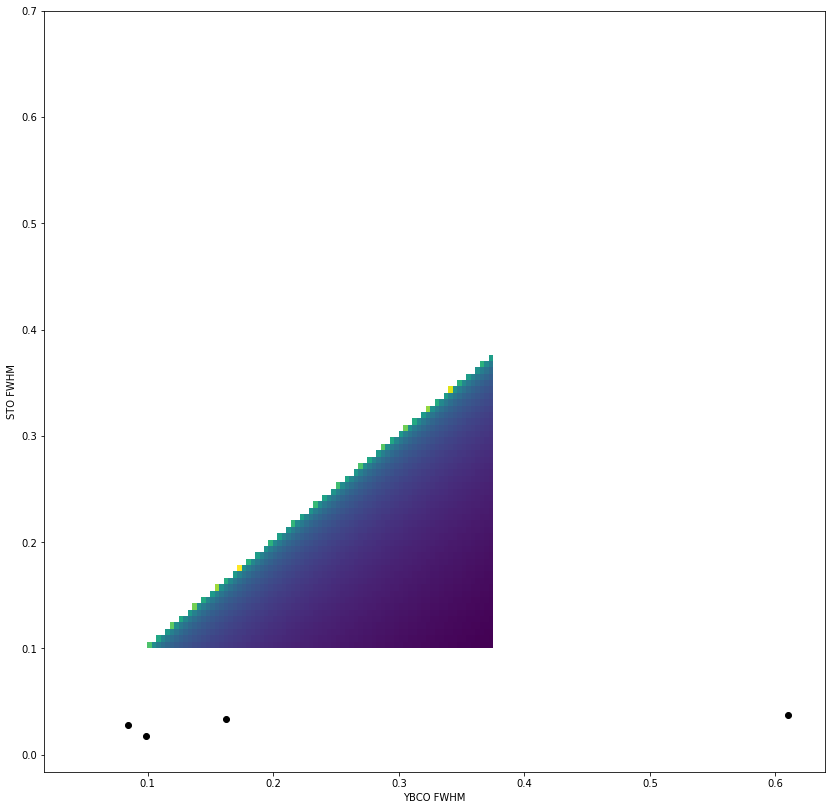

In [20]:
_sto_fwhm_v = np.linspace(0.0175, 0.375, 100)
_ybco_fwhm_v = np.linspace(0.1, 0.7, 100)

_ybco_fwhm, _sto_fwhm = np.meshgrid(_sto_fwhm_v, _ybco_fwhm_v)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
ax.imshow(np.log(scherrer_fwhm(15, _ybco_fwhm, _sto_fwhm)), cmap='viridis',aspect='auto', origin='lower', extent=[np.min(_ybco_fwhm), np.max(_ybco_fwhm), np.min(_sto_fwhm), np.max(_sto_fwhm)])
ax.plot([v for k, v in fwhm_film.items()], [v for k, v in fwhm_sto.items()], 'ok')
ax.set_xlabel('YBCO FWHM')
ax.set_ylabel('STO FWHM')